In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os 
import ydata_profiling as yp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve


In [2]:
df = pd.read_csv('../data/data_outliers_cap_features_select.csv')
df.head()

country      category  year  month  week_number  current_price     ratio  \
0  Germany      TRAINING  2016      3           12           3.95  0.663866   
1  Germany      TRAINING  2016      3           12           3.95  0.663866   
2  Germany          GOLF  2016      3           12           3.95  0.663866   
3  Germany       RUNNING  2016      3           12           3.95  0.663866   
4  Germany  RELAX CASUAL  2016      3           12           3.95  0.663866   

   promo1  promo2  label  
0       0       0      0  
1       0       0      0  
2       0       0      0  
3       0       0      0  
4       0       0      0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        99955 non-null  object 
 1   category       99955 non-null  object 
 2   year           99955 non-null  int64  
 3   month          99955 non-null  int64  
 4   week_number    99955 non-null  int64  
 5   current_price  99955 non-null  float64
 6   ratio          99955 non-null  float64
 7   promo1         99955 non-null  int64  
 8   promo2         99955 non-null  int64  
 9   label          99955 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 7.6+ MB


In [4]:
repeat = False

if not os.path.exists("../reports/third_eda_report.html") or repeat:
    profile = yp.ProfileReport(df)
    profile.to_file("../reports/third_eda_report.html")

In [5]:
# Check for Duplicates
df.duplicated().sum()

35556

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.describe(include='object')

country  category
count     64399     64399
unique        3         6
top     Germany  TRAINING
freq      31532     12420

In [8]:
df.describe().round(2)

year     month  week_number  current_price     ratio    promo1  \
count  64399.00  64399.00     64399.00       64399.00  64399.00  64399.00   
mean    2015.71      5.77        23.80          29.81      0.57      0.07   
std        0.72      3.54        15.72          23.25      0.20      0.25   
min     2014.00      1.00         1.00           1.95      0.30      0.00   
25%     2015.00      3.00         9.00          12.95      0.39      0.00   
50%     2016.00      5.00        22.00          22.95      0.57      0.00   
75%     2016.00      9.00        37.00          39.95      0.72      0.00   
max     2017.00     12.00        53.00         139.45      1.00      1.00   

         promo2     label  
count  64399.00  64399.00  
mean       0.01      0.18  
std        0.07      0.39  
min        0.00      0.00  
25%        0.00      0.00  
50%        0.00      0.00  
75%        0.00      0.00  
max        1.00      1.00

# Data Split

In [9]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51519, 9), (12880, 9), (51519,), (12880,))

# Data Preprocessing

In [10]:
preprocessor = ColumnTransformer([ ('cat', OneHotEncoder(drop='first', sparse_output=False), ['country', 'category']),
                                 ], remainder='passthrough')
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep.shape, X_test_prep.shape

((51519, 14), (12880, 14))

# Logistic Regression

In [11]:
log_reg = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')

lr_cv_results = cross_validate(log_reg, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(lr_cv_results['test_accuracy'].mean())
print(lr_cv_results['test_precision'].mean())
print(lr_cv_results['test_recall'].mean())
print(lr_cv_results['test_f1'].mean())
print(lr_cv_results['test_roc_auc'].mean())

0.7366020393414932
0.3922503969805254
0.8033772729094087
0.5271219195748895
0.8340584221738592


In [12]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 10],
    'penalty': ['l1', 'l2']
}

log_reg_grid_search = GridSearchCV(log_reg, log_reg_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
log_reg_grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 10], 'penalty': ['l1', 'l2']},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [13]:
log_reg_grid_search_results = pd.DataFrame(log_reg_grid_search.cv_results_)
log_reg_grid_search_results = log_reg_grid_search_results[['param_C', 'param_penalty', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
log_reg_grid_search_results.round(2)

param_C param_penalty  mean_test_accuracy  mean_test_precision  \
0    0.01            l1                0.73                 0.39   
1    0.01            l2                0.73                 0.39   
2     0.1            l1                0.74                 0.39   
3     0.1            l2                0.74                 0.39   
4      10            l1                0.74                 0.39   
5      10            l2                0.74                 0.39   

   mean_test_recall  mean_test_f1  
0              0.81          0.52  
1              0.80          0.52  
2              0.80          0.53  
3              0.81          0.53  
4              0.80          0.53  
5              0.80          0.53

In [14]:
best_log_reg_params = {
    'C': 0.1,
    'penalty': 'l2'}

best_log_reg = LogisticRegression(**best_log_reg_params, random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')
best_log_reg.fit(X_train_prep, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000,
                   random_state=42, solver='liblinear')

	 Log Reg classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     42105
           1       0.39      0.81      0.53      9414

    accuracy                           0.74     51519
   macro avg       0.67      0.76      0.67     51519
weighted avg       0.84      0.74      0.76     51519

############################################################
	 Log Reg confusion matrix on training set
############################################################


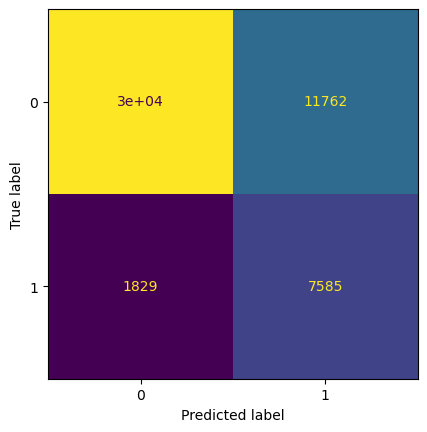

In [15]:
y_train_pred_lr = best_log_reg.predict(X_train_prep)

print("\t Log Reg classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_lr))
print('#'*60)

print("\t Log Reg confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_lr, colorbar=False)

# Random Forest

In [16]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_cv_results = cross_validate(rf, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(rf_cv_results['test_accuracy'].mean())
print(rf_cv_results['test_precision'].mean())
print(rf_cv_results['test_recall'].mean())
print(rf_cv_results['test_f1'].mean())
print(rf_cv_results['test_roc_auc'].mean())

0.7331081393708521
0.19419009256722372
0.14627126879970292
0.16685501013137888
0.7154490312928561


In [17]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt'],
    'max_depth': [10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
rf_grid_search.fit(X_train_prep, y_train)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [18]:
rf_grid_search_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_grid_search_results = rf_grid_search_results[['param_n_estimators', 'param_max_depth', 'param_max_features',  'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
rf_grid_search_results.round(2)

param_n_estimators param_max_depth param_max_features  mean_test_accuracy  \
0                 100              10               None                0.70   
1                 200              10               None                0.70   
2                 300              10               None                0.70   
3                 100              10               sqrt                0.69   
4                 200              10               sqrt                0.69   
5                 300              10               sqrt                0.69   
6                 100              20               None                0.73   
7                 200              20               None                0.73   
8                 300              20               None                0.73   
9                 100              20               sqrt                0.74   
10                200              20               sqrt                0.74   
11                300              20               sqrt                0.74   
12                100              30               None                0.74   
13                200              30               None                0.74   
14                300              30               None                0.74   
15                100              30               sqrt                0.74   
16                200              30               sqrt                0.74   
17                300              30               sqrt                0.75   

    mean_test_precision  mean_test_recall  mean_test_f1  
0                  0.37              0.87          0.52  
1                  0.37              0.87          0.52  
2                  0.37              0.88          0.52  
3                  0.36              0.90          0.52  
4                  0.36              0.90          0.52  
5                  0.36              0.90          0.52  
6                  0.29              0.33          0.31  
7                  0.29              0.33          0.31  
8                  0.29              0.33          0.31  
9                  0.27              0.26          0.26  
10                 0.27              0.26          0.26  
11                 0.27              0.25          0.26  
12                 0.21              0.16          0.18  
13                 0.21              0.16          0.18  
14                 0.21              0.16          0.18  
15                 0.22              0.15          0.18  
16                 0.22              0.15          0.18  
17                 0.22              0.15          0.18

In [19]:
rf_grid_search_best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt'
}

best_rf = RandomForestClassifier(**rf_grid_search_best_params, random_state=42, class_weight='balanced')
best_rf.fit(X_train_prep, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

	 RF classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     42105
           1       0.38      0.95      0.54      9414

    accuracy                           0.70     51519
   macro avg       0.68      0.80      0.66     51519
weighted avg       0.87      0.70      0.74     51519

############################################################
	 RF confusion matrix on training set
############################################################


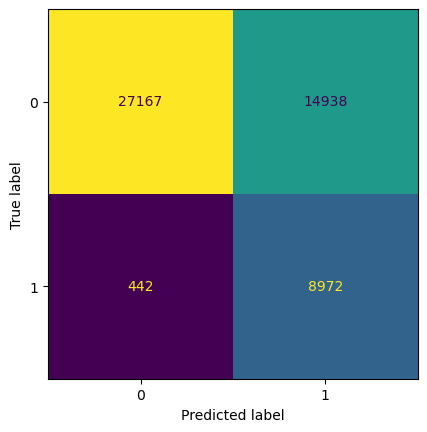

In [20]:
y_train_pred_rf = best_rf.predict(X_train_prep)

print("\t RF classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_rf))
print('#'*60)

print("\t RF confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf, colorbar=False)

# XGBoost

In [21]:
xgb = XGBClassifier(random_state=42)

xgb_cv_results = cross_validate(xgb, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(xgb_cv_results['test_accuracy'].mean())
print(xgb_cv_results['test_precision'].mean())
print(xgb_cv_results['test_recall'].mean())
print(xgb_cv_results['test_f1'].mean())
print(xgb_cv_results['test_roc_auc'].mean())

0.7959005224010616
0.32285353002654904
0.1064371469544326
0.15996906504493355
0.7999232462790353


In [22]:
xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30],
    'learning_rate': [0.01, 0.1, 1]
}

xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
xgb_grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 1], 'max_depth': [20, 30],
                         'n_estimators': [200, 300, 400]},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [23]:
xgb_grid_search_results = pd.DataFrame(xgb_grid_search.cv_results_)
xgb_grid_search_results = xgb_grid_search_results[['param_n_estimators', 'param_max_depth', 'param_learning_rate',  'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
xgb_grid_search_results.round(2)

param_n_estimators param_max_depth param_learning_rate  mean_test_accuracy  \
0                 200              20                0.01                0.78   
1                 300              20                0.01                0.76   
2                 400              20                0.01                0.75   
3                 200              30                0.01                0.77   
4                 300              30                0.01                0.76   
5                 400              30                0.01                0.75   
6                 200              20                 0.1                0.74   
7                 300              20                 0.1                0.73   
8                 400              20                 0.1                0.73   
9                 200              30                 0.1                0.74   
10                300              30                 0.1                0.73   
11                400              30                 0.1                0.73   
12                200              20                   1                0.73   
13                300              20                   1                0.73   
14                400              20                   1                0.73   
15                200              30                   1                0.73   
16                300              30                   1                0.73   
17                400              30                   1                0.73   

    mean_test_precision  mean_test_recall  mean_test_f1  
0                  0.21              0.08          0.12  
1                  0.22              0.12          0.16  
2                  0.23              0.14          0.17  
3                  0.21              0.08          0.12  
4                  0.21              0.13          0.16  
5                  0.22              0.14          0.17  
6                  0.22              0.18          0.20  
7                  0.23              0.19          0.20  
8                  0.23              0.19          0.21  
9                  0.23              0.19          0.21  
10                 0.23              0.19          0.21  
11                 0.23              0.19          0.21  
12                 0.23              0.21          0.22  
13                 0.23              0.21          0.22  
14                 0.23              0.21          0.22  
15                 0.23              0.20          0.22  
16                 0.23              0.21          0.22  
17                 0.23              0.21          0.22

In [24]:
print("\t Log Reg classification report on training set")
print(classification_report(y_train, y_train_pred_lr))

print('#'*60)

print("\t RF classification report on training set")
print(classification_report(y_train, y_train_pred_rf))

	 Log Reg classification report on training set
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     42105
           1       0.39      0.81      0.53      9414

    accuracy                           0.74     51519
   macro avg       0.67      0.76      0.67     51519
weighted avg       0.84      0.74      0.76     51519

############################################################
	 RF classification report on training set
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     42105
           1       0.38      0.95      0.54      9414

    accuracy                           0.70     51519
   macro avg       0.68      0.80      0.66     51519
weighted avg       0.87      0.70      0.74     51519



In [25]:
y_train_proba_lr = best_log_reg.predict_proba(X_train_prep)[:, 1]
y_train_proba_rf = best_rf.predict_proba(X_train_prep)[:, 1]

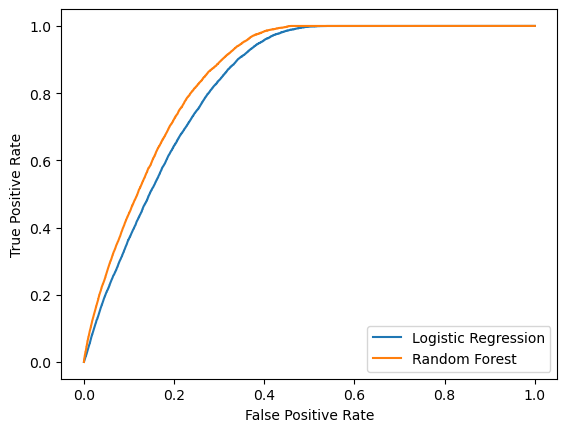

In [26]:
lr_fpr, lr_tpr, _ = roc_curve(y_train, y_train_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_train, y_train_proba_rf)

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

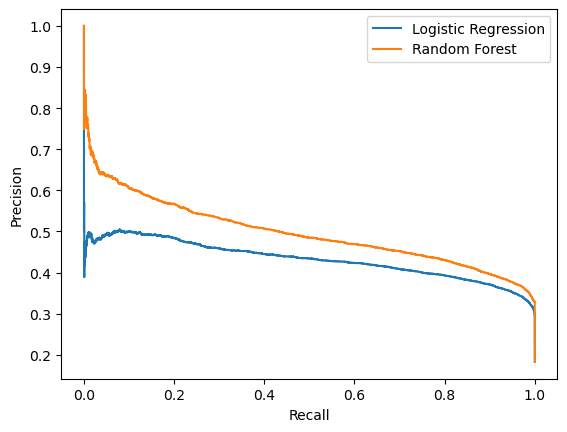

In [27]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_train, y_train_proba_lr)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_train, y_train_proba_rf)

plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [28]:
import plotly.express as px

fig = px.line(x=rf_recall[:-1], y=rf_precision[:-1], hover_data=[rf_thresholds], title='Precision-Recall Tradeoff', width=600, height=500)
fig.update_layout(xaxis_title='Recall', yaxis_title='Precision', showlegend=False)
fig.show()


	 RF classification report on training set
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     42105
           1       0.44      0.78      0.56      9414

    accuracy                           0.78     51519
   macro avg       0.69      0.78      0.70     51519
weighted avg       0.85      0.78      0.80     51519



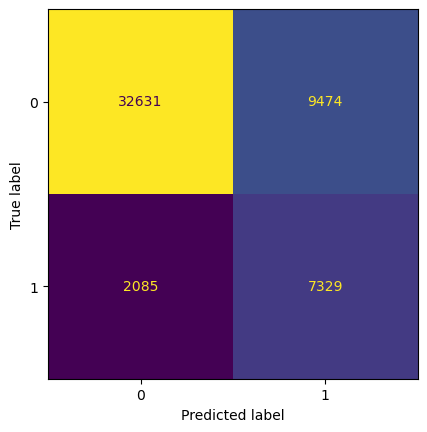

In [29]:
# For Rf: we will increase Probability threshold
prob_threshold = 0.65
rf_train_pred = best_rf.predict_proba(X_train_prep)[:, 1] > prob_threshold

print("\t RF classification report on training set")
print(classification_report(y_train, rf_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_train_pred, colorbar=False)

In [30]:
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ('prep', preprocessor),
    ('rf', best_rf)
])


best_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['country', 'category'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])

In [31]:
# Predict on test data
prob_threshold = 0.65
y_test_pred = best_model.predict_proba(X_test_prep)[:, 1] > prob_threshold

print("\t RF classification report on test set")
print('#'*60)
print(classification_report(y_test, y_test_pred))
print('#'*60)

print("\t RF confusion matrix on test set")
print('#'*60)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, colorbar=False)

ValueError: X has 14 features, but ColumnTransformer is expecting 9 features as input.

| Strategy Type               | Threshold | Precision (1) | Recall (1) | Comment                   |
| --------------------------- | --------- | ------------- | ---------- | ------------------------- |
| Conservative (save cost)    | 0.7       | 0.39          | 0.48       | Misses buyers             |
| **Balanced (recommended)**  | 0.65      | 0.38          | 0.68       | ✅ Best trade-off so far   |
| Aggressive (maximize reach) | 0.5       | ↓             | ↑          | Higher recall, but costly |


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

In [ ]:
# From Prev. EDA
profit_per_conversion = 804.5 
cost_per_offer = 6.5        

# Expected profit
expected_profit = (tp * profit_per_conversion) - ((tp + fp) * cost_per_offer)

print(f"Expected profit is {expected_profit}")
print(f"Expected profit per customer is {expected_profit / (tp + fp)}")
print(f"Expected profit per offer is {expected_profit / (tp + fn)}")


Expected profit is 1252802.5
Expected profit per customer is 299.85698898994735
Expected profit per offer is 532.4277518062048


In [ ]:
def evaluate_campaign_roi(y_true, y_probs, profit_per_conversion, cost_per_offer, threshold=0.5, verbose=True):   
    """
    Evaluates ROI and classification metrics for a marketing campaign model.
    
    Args:
        y_true (array-like): True labels (0 or 1)
        y_probs (array-like): Predicted probabilities for class 1
        threshold (float): Probability threshold for classification
        profit_per_conversion (float): Net profit per successful conversion
        cost_per_offer (float): Cost per customer targeted
        verbose (bool): Whether to print results

    Returns:
        dict: Dictionary with TP, FP, FN, TN, profit, cost, ROI, accuracy, precision, recall
    """
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = (tp + fp) * cost_per_offer
    total_revenue = tp * profit_per_conversion
    net_profit = total_revenue - total_cost
    roi = net_profit / total_cost if total_cost > 0 else 0

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn)

    result = {
        'threshold': threshold,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
        'total_cost': total_cost,
        'total_revenue': total_revenue,
        'net_profit': net_profit,
        'roi': roi,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }

    if verbose:
        print(f"\nThreshold: {threshold}")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
        print(f"Total Campaign Cost: ${total_cost:,.0f}")
        print(f"Total Profit from Buyers: ${total_revenue:,.0f}")
        print(f"Net Profit: ${net_profit:,.0f}")
        print(f"ROI: {roi:.2f}")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")

    return result


In [ ]:
for th in [0.2, 0.3, 0.4, 0.5, 0.6, 0.65,0.7, 0.8, 0.9]:
    print(evaluate_campaign_roi(y_test, best_model.predict_proba(X_test_prep)[:, 1], profit_per_conversion, cost_per_offer, threshold=th, verbose=False))
    print('#'*60)

{'threshold': 0.2, 'TP': 2333, 'FP': 4923, 'FN': 20, 'TN': 5604, 'total_cost': 47164.0, 'total_revenue': 1876898.5, 'net_profit': 1829734.5, 'roi': 38.79515096259859, 'precision': 0.32152701212789414, 'recall': 0.9915002124946877, 'accuracy': 0.6162267080745342}
############################################################
{'threshold': 0.3, 'TP': 2316, 'FP': 4765, 'FN': 37, 'TN': 5762, 'total_cost': 46026.5, 'total_revenue': 1863222.0, 'net_profit': 1817195.5, 'roi': 39.48150521981902, 'precision': 0.3270724473944358, 'recall': 0.9842753931151721, 'accuracy': 0.6271739130434782}
############################################################
{'threshold': 0.4, 'TP': 2245, 'FP': 4416, 'FN': 108, 'TN': 6111, 'total_cost': 43296.5, 'total_revenue': 1806102.5, 'net_profit': 1762806.0, 'roi': 40.71474599563475, 'precision': 0.3370364810088575, 'recall': 0.9541011474713132, 'accuracy': 0.6487577639751553}
############################################################
{'threshold': 0.5, 'TP': 2112

| Threshold | ROI       | Precision | Recall | Net Profit | Notes                                  |
| --------- | --------- | --------- | ------ | ---------- | -------------------------------------- |
| **0.2**   | 38.8x     | 0.32      | 99%    | \$1.83M    | Huge reach, but many wasted offers     |
| **0.3**   | 39.5x     | 0.33      | 98%    | \$1.82M    | Slightly better ROI, still broad       |
| **0.4**   | 40.7x     | 0.34      | 95%    | \$1.76M    | Tradeoff starts — better targeting     |
| **0.5**   | 42.8x     | 0.35      | 90%    | \$1.66M    | Sharper targeting, still solid ROI     |
| **0.6**   | 44.8x     | 0.37      | 78%    | \$1.45M    | Great ROI, fewer wasted offers         |
| **0.65**  | 46.1x     | 0.38      | 68%    | \$1.25M    | ✅ Best balance so far                  |
| **0.7**   | **47.5x** | 0.39      | 48%    | \$894K     | 🔥 Highest ROI, but many missed buyers |
| **0.8**   | -1.0      | 0.00      | 0%     | -\$84      | Too strict — killed the campaign       |
| **0.9**   | 0         | 0.00      | 0%     | \$0        | No campaign at all                     |


# Save Model

In [ ]:
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump((best_model, prob_threshold), '../models/rf_model_outliers_cap_with_threshold.joblib')

['../models/rf_model_with_threshold.joblib']

In [ ]:
df.sample(5)

country          category  year  month  week_number  current_price  \
64063   France           RUNNING  2016      9           38           4.95   
61892  Germany              GOLF  2015      8           33          23.95   
31737   France            INDOOR  2016      6           25          66.95   
72837  Germany      RELAX CASUAL  2015      9           36           9.95   
16586  Austria  FOOTBALL GENERIC  2016      7           26          24.95   

          ratio  promo1  promo2  label  
64063  0.310345       0       0      0  
61892  0.532814       0       0      0  
31737  0.531560       0       0      0  
72837  0.369202       0       0      0  
16586  0.780908       0       0      1